In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('structured_dialogues.csv')
df.head()

,Movie Title,Year,Dialogue
0,Veer Zaara,2004,One early morning
1,Veer Zaara,2004,Lifting the dark misty veil
2,Veer Zaara,2004,of the night
3,Veer Zaara,2004,From its pillow of its mountain peak
4,Veer Zaara,2004,the Sun rose and saw...


In [3]:
print(df.isnull().sum())

Movie Title    0
Year           0
Dialogue       1
dtype: int64


In [4]:
df = df.fillna('-')
print(df.isnull().sum())

Movie Title    0
Year           0
Dialogue       0
dtype: int64


In [5]:
print(df.duplicated().sum())


10033


In [6]:
vz = df.copy()
vz.iloc[22945]

Movie Title    Chak De India
Year                    2007
Dialogue               Sorry
Name: 22945, dtype: object

In [7]:
df.tail()

,Movie Title,Year,Dialogue
123226,Animal,2023,Good.
123227,Animal,2023,You were the one singing while
123228,Animal,2023,"he was taking my brother's life, right?"
123229,Animal,2023,And you were the one who
123230,Animal,2023,handed him a knife at the runway.


In [8]:
df = df.groupby('Movie Title', group_keys=False).apply(lambda x: x.drop_duplicates(subset='Dialogue', keep='first'))
print(df.duplicated().sum())

0


/var/folders/sd/pnj3p8654m1b580n1b78tlkc0000gn/T/ipykernel_6531/1367022659.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Movie Title', group_keys=False).apply(lambda x: x.drop_duplicates(subset='Dialogue', keep='first'))


In [9]:
df_grouped = df.groupby(["Movie Title", "Year"])["Dialogue"].apply(" ".join).reset_index()

# Rename the column for clarity
df_grouped.rename(columns={"Dialogue": "Full Script"}, inplace=True)

print(df_grouped.head())

                  Movie Title  Year  \
0                    3 Idiots  2009   
1          Ae Dil Hai Mushkil  2016   
2                     Airlift  2016   
3  Ajab Prem Ki Ghazab Kahani  2009   
4                      Animal  2023   

                                         Full Script  
0  Hello Yes? What? Sir, kindly switch off your m...  
1  What's wrong with this city? Somewhere there a...  
2  And finally... How do you fit 30 Iraqis in one...  
3  <font color=fuchsia size=20> <i>Movie & Captio...  
4  POWER PROGRESS VICTORY 40th birthday, 50th bir...  


In [10]:
import re
import spacy
import en_core_web_sm

In [11]:
nlp = en_core_web_sm.load()


In [12]:
def preprocess_text(text): #nlp preprocess
    text = text.lower()  
    text = re.sub(r"[^a-z\s]", "", text)  #
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]  
    return " ".join(tokens)

In [13]:
df_grouped["Processed Script"] = df_grouped["Full Script"].apply(preprocess_text)

In [158]:
print(df_grouped.head())


                  Movie Title  Year  \
0                    3 Idiots  2009   
1          Ae Dil Hai Mushkil  2016   
2                     Airlift  2016   
3  Ajab Prem Ki Ghazab Kahani  2009   
4                      Animal  2023   

                                         Full Script  \
0  Hello Yes? What? Sir, kindly switch off your m...   
1  What's wrong with this city? Somewhere there a...   
2  And finally... How do you fit 30 Iraqis in one...   
3  <font color=fuchsia size=20> <i>Movie & Captio...   
4  POWER PROGRESS VICTORY 40th birthday, 50th bir...   

                                    Processed Script  
0  hello yes sir kindly switch mobile phone sec e...  
1  s wrong city ashe smoke not endure smoke quiet...  
2  finally fit   iraqis telephone booth tell belo...  
3  font colorfuchsia size imovie   captioning con...  
4  power progress victory th birthday th birthday...  


In [159]:
df_grouped.to_csv("processed_movie_scripts.csv", index=True)

In [160]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [161]:
final_riz_df = pd.read_csv("processed_movie_scripts.csv")


In [162]:
misrepresentation_keywords = {
    "terrorism": [
        "jihad", "jihadist", "suicide bomber", "islamic terrorism", "terror cell", 
        "radical islam", "terror attack", "militant group", "holy war",
        "bomb", "martyr", "radical", "extremist", "militant", "allahu akbar", "god is great", "inshallah", "takbir", "mujahid", 
        "alhamdulillah", "la ilaha illallah", "deen", "umma", "shahada", 
    ],

    "anger": [
        "furiously shouted", "slapped", "punched", "violent temper", "uncontrollable rage",
        "abusive language", "violent outburst", "temper tantrum",
        "rage", "furious", "short temper", "yelled", "screamed", "snapped", "exploded"
    ],

    "superstition": [
        "divine punishment", "allahu akbar", "black magic", "sharia"
        "holy blessing", "superstitious belief", "demonic possession",
        "primitive tradition", "backward thinking", "religious law", "old ways", 
        "anti-modern", "ancient customs", "superstition", "orthodox",
    ],

    "threat_to_western": [
        "anti-democracy", "death to the west", "sharia law", "dictatorship",
        "destroy freedom", "corrupt government", "overthrow system",
        "gang activity", "underground network", "illegal trade", "contraband", 
        "arms dealer", "trafficking", "fundamentalism"
    ],

    "misogyny": [
        "honor killing", "forced marriage", "child bride", "male authority", 
        "domestic abuse", "rape", "molestation", "harassment", "submission",
        "serve her husband", "woman's duty", "women belong at home", "female obedience",
        "obedient wife", "women are weak", "man's world", "female servant", 
        "treats women like property", "prostitution", "used for pleasure"
    ]
}

In [163]:

for category in misrepresentation_keywords:
    final_riz_df[category] = 0


In [164]:
# keyword matching
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(final_riz_df["Processed Script"])


In [165]:
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())


In [166]:
# check keyword is present in each script
for category, keywords in misrepresentation_keywords.items():
    # filter words that are not in TF-IDF matrix
    existing_keywords = [word for word in keywords if word in tfidf_df.columns]
    
    if existing_keywords: # proceed if at least one keyword exists in TF-IDF features
        final_riz_df[category] = tfidf_df[existing_keywords].sum(axis=1).apply(lambda x: 1 if x > 0 else 0)
    else:
        final_riz_df[category] = 0  # If no keywords exist, set column to 0

In [167]:
# For each movie, collect flagged words from each category
def get_flagged_words(processed_script):
    flagged = []
    for category, keywords in misrepresentation_keywords.items():
        for word in keywords:
            # Only add if the word is present in the processed script
            if word in processed_script.split():
                flagged.append(word)
    return list(set(flagged))  # Remove duplicates

final_riz_df["flagged_words"] = final_riz_df["Processed Script"].apply(get_flagged_words)

In [168]:
final_riz_df.head()

,Unnamed: 0,Movie Title,Year,Full Script,Processed Script,terrorism,anger,superstition,threat_to_western,misogyny,flagged_words
0,0,3 Idiots,2009,"Hello Yes? What? Sir, kindly switch off your m...",hello yes sir kindly switch mobile phone sec e...,0,0,0,0,0,[]
1,1,Ae Dil Hai Mushkil,2016,What's wrong with this city? Somewhere there a...,s wrong city ashe smoke not endure smoke quiet...,0,0,0,0,0,[]
2,2,Airlift,2016,And finally... How do you fit 30 Iraqis in one...,finally fit iraqis telephone booth tell belo...,0,0,0,0,0,[]
3,3,Ajab Prem Ki Ghazab Kahani,2009,<font color=fuchsia size=20> <i>Movie & Captio...,font colorfuchsia size imovie captioning con...,1,0,0,0,0,[bomb]
4,4,Animal,2023,"POWER PROGRESS VICTORY 40th birthday, 50th bir...",power progress victory th birthday th birthday...,1,1,0,0,0,"[bomb, furious]"


In [169]:
# add final riz score
final_riz_df["riz_score"] = final_riz_df[list(misrepresentation_keywords.keys())].sum(axis=1)

In [170]:
final_riz_df.drop(["Processed Script", "Full Script", "Unnamed: 0"], axis=1, inplace=True)
final_riz_df = final_riz_df.sort_values(by='Year', ascending=True)
final_riz_df.to_csv("riz_test_results.csv", index=False)

In [171]:
final_riz_df.head()

,Movie Title,Year,terrorism,anger,superstition,threat_to_western,misogyny,flagged_words,riz_score
56,Veer Zaara,2004,0,0,0,0,0,[],0
28,Main Hoon Na,2004,0,0,0,0,0,[],0
15,Dhoom,2004,1,0,0,0,0,[martyr],1
29,Mangal Pandey,2005,0,1,1,0,0,"[rage, superstition]",2
41,Sarkar,2005,0,0,0,0,1,[rape],1


In [172]:
final_riz_df["terrorism"].sum()

np.int64(29)

In [173]:
final_riz_df["anger"].sum()

np.int64(16)

In [174]:
final_riz_df["superstition"].sum()

np.int64(3)

In [175]:
final_riz_df["threat_to_western"].sum()

np.int64(0)

In [176]:
final_riz_df["misogyny"].sum()

np.int64(10)

In [177]:
import matplotlib.pyplot as plt
import numpy as np

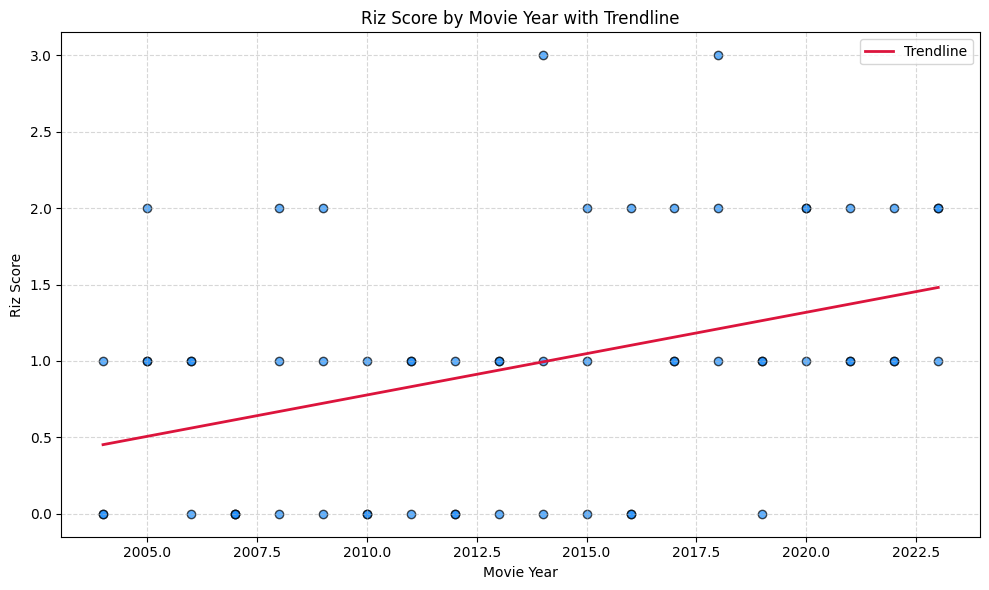

In [178]:
# Fit a basic linear regression line (no ML involved)
coeffs = np.polyfit(final_riz_df["Year"], final_riz_df["riz_score"], deg=1)
trendline = np.poly1d(coeffs)

# Plot with trendline
plt.figure(figsize=(10, 6))
plt.scatter(final_riz_df["Year"], final_riz_df["riz_score"], color="dodgerblue", edgecolors='k', alpha=0.7)
plt.plot(final_riz_df["Year"], trendline(final_riz_df["Year"]), color="crimson", linewidth=2, label="Trendline")
plt.xlabel("Movie Year")
plt.ylabel("Riz Score")
plt.title("Riz Score by Movie Year with Trendline")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [179]:
correlation = final_riz_df["Year"].corr(final_riz_df["riz_score"])
print(f"Pearson correlation coefficient (r): {correlation:.3f}")

Pearson correlation coefficient (r): 0.383


In [180]:
# The slope is the first coefficient in the polyfit result used for trendline
slope = coeffs[0]
print(f"Slope of the regression line: {slope}")

Slope of the regression line: 0.05413533834586366
